<a href="https://colab.research.google.com/github/mateo020/IBM_capstone/blob/main/capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Space X  Falcon 9 First Stage Landing Prediction**


## Web scraping Falcon 9 and Falcon Heavy Launches Records from Wikipedia


Falcon 9 first stage will land successfully


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


In [1]:
!pip3 install beautifulsoup4
!pip3 install requests

In [2]:
import sys

import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

and we will provide some helper functions for you to process web scraped HTML table


In [3]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()

    colunm_name = ' '.join(row.contents)

    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name


To keep the lab tasks consistent, you will be asked to scrape the data from a snapshot of the  `List of Falcon 9 and Falcon Heavy launches` Wikipage updated on
`9th June 2021`


In [4]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

Next, request the HTML page from the above URL and get a `response` object


### TASK 1: Request the Falcon9 Launch Wiki page from its URL


First, let's perform an HTTP GET method to request the Falcon9 Launch HTML page, as an HTTP response.


In [5]:
# use requests.get() method with the provided static_url
# assign the response to a object
response = requests.get(static_url)

Create a `BeautifulSoup` object from the HTML `response`


In [6]:
# Use BeautifulSoup() to create a BeautifulSoup object from a response text content
soup = BeautifulSoup(response.content)

Print the page title to verify if the `BeautifulSoup` object was created properly


In [7]:
# Use soup.title attribute
soup.title

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>

### TASK 2: Extract all column/variable names from the HTML table header


Next, we want to collect all relevant column names from the HTML table header


In [8]:
# Use the find_all function in the BeautifulSoup object, with element type `table`
# Assign the result to a list called `html_tables`
html_tables = soup.find_all('table')



In [9]:
# Let's print the third table and check its content
first_launch_table = html_tables[2]


```
<tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11">[b]</a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12">[c]</a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 9 first-stage landing tests">Booster<br/>landing</a>
</th></tr>
```


Next, we just need to iterate through the `<th>` elements and apply the provided `extract_column_from_header()` to extract column name one by one


In [10]:
column_names = []

# Apply find_all() function with `th` element on first_launch_table
# Iterate each th element and apply the provided extract_column_from_header() to get a column name
# Append the Non-empty column name (`if name is not None and len(name) > 0`) into a list called column_names

ths = first_launch_table.find_all('th')
for e in ths:
  if extract_column_from_header(e) != None and extract_column_from_header(e) != '':
    column_names.append(extract_column_from_header(e))


Check the extracted column names


In [11]:
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


##Create a data frame by parsing the launch HTML tables


We will create an empty dictionary with keys from the extracted column names in the previous task. Later, this dictionary will be converted into a Pandas dataframe


In [12]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

Next, we just need to fill up the `launch_dict` with launch records extracted from table rows.


In [13]:
extracted_row = 0
#Extract each table
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element
        row=rows.find_all('td')


In [14]:
extracted_row = 0
#Extract each table
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
  # get table row
  for rows in table.find_all("tr"):
      #check to see if first table heading is as number corresponding to launch a number
      if rows.th:
          if rows.th.string:
              flight_number=rows.th.string.strip()
              flag=flight_number.isdigit()
      else:
          flag=False
      #get table element
      row=rows.find_all('td')
      #if it is number save cells in a dictonary
      if flag:
          extracted_row += 1
          # Flight Number value
          # Append the flight_number into launch_dict with key `Flight No.`
          launch_dict['Flight No.'].append(flight_number)


          datatimelist=date_time(row[0])


          # Date value
          # Append the date into launch_dict with key `Date`
          date = datatimelist[0].strip(',')

          launch_dict['Date'].append(date)

          # Time value
          # Append the time into launch_dict with key `Time`
          time = datatimelist[1]

          launch_dict['Time'].append(time)

          # Booster version
          # Append the bv into launch_dict with key `Version Booster`
          bv=booster_version(row[1])
          if not(bv):
              bv=row[1].a.string

          launch_dict['Version Booster'].append(bv)

          # Launch Site
          # Append the bv into launch_dict with key `Launch Site`
          launch_site = row[2].a.string

          launch_dict['Launch site'].append(launch_site)


          # Payload
          # Append the payload into launch_dict with key `Payload`
          payload = row[3].a.string



          # Payload Mass
          # Append the payload_mass into launch_dict with key `Payload mass`
          payload_mass = get_mass(row[4])


          launch_dict['Payload mass'].append(payload_mass)
          launch_dict['Payload'].append(payload)

          # Orbit
          # Append the orbit into launch_dict with key `Orbit`
          orbit = row[5].a.string

          launch_dict['Orbit'].append(orbit)

          # Customer
          # Append the customer into launch_dict with key `Customer`
          if row[6].a != None:
            customer = row[6].a.string

            launch_dict['Customer'].append(customer)
          else:
            launch_dict['Customer'].append(None)


          # Launch outcome
          # Append the launch_outcome into launch_dict with key `Launch outcome`
          launch_outcome = list(row[7].strings)[0]

          if '\n' in launch_outcome:
            launch_outcome.replace('\n', '')
          launch_dict['Launch outcome'].append(launch_outcome)

          # Booster landing
          #Append the launch_outcome into launch_dict with key `Booster landing`
          booster_landing = landing_status(row[8])

          launch_dict['Booster landing'].append(booster_landing)


After you have fill in the parsed launch record values into `launch_dict`, you can create a dataframe from it.


In [15]:
print(len(launch_dict['Flight No.']))
print(len(launch_dict['Launch site']))
print(len(launch_dict['Payload']))
print(len(launch_dict['Payload mass']))
print(len(launch_dict['Orbit']))
print(len(launch_dict['Customer']))
print(len(launch_dict['Launch outcome']))
print(len(launch_dict['Version Booster']))
print(len(launch_dict['Booster landing']))
print(len(launch_dict['Date']))
print(len(launch_dict['Time']))


121
121
121
121
121
121
121
121
121
121
121


In [16]:

df=pd.DataFrame(launch_dict)

In [17]:
df

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.0B0003.1,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.0B0005.1,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.0B0006.1,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.0B0007.1,No attempt\n,1 March 2013,15:10
...,...,...,...,...,...,...,...,...,...,...,...
116,117,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success\n,F9 B5B1051.10,Success,9 May 2021,06:42
117,118,KSC,Starlink,"~14,000 kg",LEO,SpaceX,Success\n,F9 B5B1058.8,Success,15 May 2021,22:56
118,119,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success\n,F9 B5B1063.2,Success,26 May 2021,18:59
119,120,KSC,SpaceX CRS-22,"3,328 kg",LEO,NASA,Success\n,F9 B5B1067.1,Success,3 June 2021,17:29


In [18]:
df['Launch outcome']= df['Launch outcome'].replace('Success\n', 'Success')

In [19]:
df

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,F9 v1.0B0003.1,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.0B0005.1,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success,F9 v1.0B0006.1,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success,F9 v1.0B0007.1,No attempt\n,1 March 2013,15:10
...,...,...,...,...,...,...,...,...,...,...,...
116,117,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success,F9 B5B1051.10,Success,9 May 2021,06:42
117,118,KSC,Starlink,"~14,000 kg",LEO,SpaceX,Success,F9 B5B1058.8,Success,15 May 2021,22:56
118,119,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success,F9 B5B1063.2,Success,26 May 2021,18:59
119,120,KSC,SpaceX CRS-22,"3,328 kg",LEO,NASA,Success,F9 B5B1067.1,Success,3 June 2021,17:29


<code>df.to_csv('spacex_web_scraped.csv', index=False)</code>


DATA FROM API

In [20]:
# Requests allows us to make HTTP requests which we will use to get data from an API
import requests
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Datetime is a library that allows us to represent dates
import datetime

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

In [21]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

In [22]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

In [23]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

In [24]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

In [25]:
spacex_url="https://api.spacexdata.com/v4/launches/past"

In [26]:
response = requests.get(spacex_url)

 ## Request and parse the SpaceX launch data using the GET request


In [27]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'


In [28]:
response.status_code

200

In [29]:
# Use json_normalize meethod to convert the json result into a dataframe
data = pd.json_normalize(response.json())

In [30]:
# Get the head of the dataframe
data.head()

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/94/f2/NN6Ph45r_o.png,https://images2.imgbox.com/5b/02/QcxHUb5V_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]","Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/f9/4a/ZboXReNb_o.png,https://images2.imgbox.com/80/a2/bkWotCIS_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",Residual stage 1 thrust led to collision between stage 1 and stage 2,[],[],[],"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdbffd86e000604b32c,False,False,False,[],https://images2.imgbox.com/6c/cb/na1tzhHs_o.png,https://images2.imgbox.com/4a/80/k1oAkY0k_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1-flight-3-mission-summary,https://en.wikipedia.org/wiki/Trailblazer_(satellite),NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],"Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1",[],[],[],[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,4,RatSat,2008-09-28T23:15:00.000Z,1222643700,2008-09-28T11:15:00+12:00,hour,False,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': 

In [31]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

In [32]:
data

,rocket,payloads,launchpad,cores,flight_number,date_utc,date
0,5e9d0d95eda69955f709d1eb,5eb0e4b5b6c3bb0006eeb1e1,5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",1,2006-03-24T22:30:00.000Z,2006-03-24
1,5e9d0d95eda69955f709d1eb,5eb0e4b6b6c3bb0006eeb1e2,5e9e4502f5090995de566f86,"{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",2,2007-03-21T01:10:00.000Z,2007-03-21
3,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e5,5e9e4502f5090995de566f86,"{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",4,2008-09-28T23:15:00.000Z,2008-09-28
4,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e6,5e9e4502f5090995de566f86,"{'core': '5e9e289ef359184f103b2627', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",5,2009-07-13T03:35:00.000Z,2009-07-13
5,5e9d0d95eda69973a809d1ec,5eb0e4b7b6c3bb0006eeb1e7,5e9e4501f509094ba4566f84,"{'core': '5e9e289ef359185f2b3b2628', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",6,2010-06-04T18:45:00.000Z,2010-06-04
...,...,...,...,...,...,...,...
101,5e9d0d95eda69973a809d1ec,5ef6a4600059c33cee4a829e,5e9e4502f509094188566f88,"{'core': '5ef670f10059c33cee4a826c', 'flight': 2, 'gridfins': True, 'legs': True, 'reused': True, 'landing_attempt': True, 'landing_success': True, 'landing_type': 'ASDS', 'landpad': '5e9e3032383ecb6bb234e7ca'}",102,2020-09-03T12:46:00.000Z,2020-09-03
102,5e9d0d95eda69973a809d1ec,5ef6a48e0059c33cee4a829f,5e9e4502f509094188566f88,"{'core': '5e9e28a7f3591817f23b2663', 'flight': 3, 'gridfins': True, 'legs': True, 'reused': True, 'landing_attempt': True, 'landing_success': True, 'landing_type': 'ASDS', 'landpad': '5e9e3032383ecb6bb234e7ca'}",103,2020-10-06T11:29:00.000Z,2020-10-06
103,5e9d0d95eda69973a809d1ec,5ef6a4d50059c33cee4a82a1,5e9e4502f509094188566f88,"{'core': '5e9e28a6f35918c0803b265c', 'flight': 6, 'gridfins': True, 'legs': True, 'reused': True, 'landing_attempt': True, 'landing_success': True, 'landing_type': 'ASDS', 'landpad': '5e9e3032383ecb6bb234e7ca'}",104,2020-10-18T12:25:00.000Z,2020-10-18
104,5e9d0d95eda69973a809d1ec,5ef6a4ea0059c33cee4a82a2,5e9e4501f509094ba4566f84,"{'core': '5ef670f10059c33cee4a826c', 'flight': 3, 'gridfins': True, 'legs': True, 'reused': True, 'landing_attempt': True, 'landing_success': True, 'landing_type': 'ASDS', 'landpad': '5e9e3033383ecbb9e534e7cc'}",105,2020-10-24T15:31:00.000Z,2020-10-24


In [33]:
#Global variables
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [34]:
BoosterVersion

[]

In [35]:
# Call getBoosterVersion
getBoosterVersion(data)

In [36]:
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

In [37]:
# Call getLaunchSite
getLaunchSite(data)

In [38]:
# Call getPayloadData
getPayloadData(data)

In [39]:
# Call getCoreData
getCoreData(data)

In [40]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}


In [41]:
# Create a data from launch_dict

df_launch = pd.DataFrame(launch_dict)

In [42]:
# Show the head of the dataframe
df_launch.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


In [43]:
# Hint data['BoosterVersion']!='Falcon 1'
data_falcon9 = df_launch.copy()
data_falcon9 = data_falcon9[data_falcon9['BoosterVersion'] != 'Falcon 1']

In [44]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


In [45]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

Data Wranggling


In [46]:
# Calculate the mean value of PayloadMass column
mean = data_falcon9['PayloadMass'].mean()
# Replace the np.nan values with its mean value
data_falcon9['PayloadMass'].fillna(mean,inplace=True)

In [47]:
data_falcon9.isnull().sum()/df.count()*100

Block              NaN
Booster landing    NaN
BoosterVersion     NaN
Customer           NaN
Date               0.0
Flight No.         NaN
FlightNumber       NaN
Flights            NaN
GridFins           NaN
LandingPad         NaN
Latitude           NaN
Launch outcome     NaN
Launch site        NaN
LaunchSite         NaN
Legs               NaN
Longitude          NaN
Orbit              0.0
Outcome            NaN
Payload            NaN
Payload mass       NaN
PayloadMass        NaN
Reused             NaN
ReusedCount        NaN
Serial             NaN
Time               NaN
Version Booster    NaN
dtype: float64

In [48]:
data_falcon9.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

In [49]:
# Apply value_counts() on column LaunchSite
data_falcon9['LaunchSite'].value_counts()


CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/Orbits.png)

Calculate the number and occurrence of each orbit

In [50]:
# Apply value_counts on Orbit column
data_falcon9['Orbit'].value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

Calculate number of mission outcomes


In [51]:
# landing_outcomes = values on Outcome column
landing_outcomes = data_falcon9['Outcome'].value_counts()
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

In [52]:
landing_outcomes.keys()

Index(['True ASDS', 'None None', 'True RTLS', 'False ASDS', 'True Ocean',
       'False Ocean', 'None ASDS', 'False RTLS'],
      dtype='object')

In [53]:
landing_sites = []
for outcome in landing_outcomes.keys():
  site = outcome.split()[1]
  if site not in landing_sites:
      landing_sites.append(site)


In [54]:
landing_sites

['ASDS', 'None', 'RTLS', 'Ocean']

In [55]:
filtered_df = data_falcon9.loc[(data_falcon9['Outcome'] == 'True ASDS') | (data_falcon9['Outcome'] == 'True ASDS')]



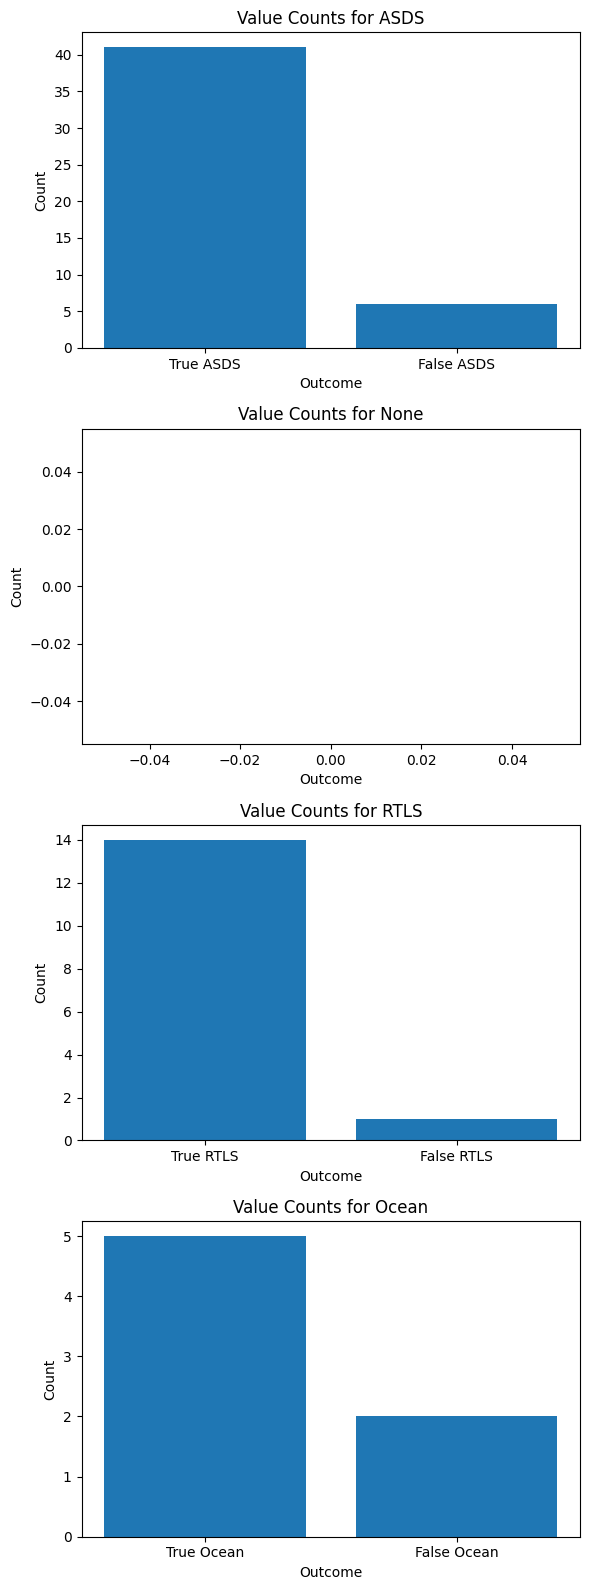

In [56]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(landing_sites), 1, figsize=(6, 4 * len(landing_sites)))

for i, site in enumerate(landing_sites):
    filtered_df = data_falcon9.loc[(data_falcon9['Outcome'] == f"False {site}") | (data_falcon9['Outcome'] == f"True {site}")]
    value_counts = filtered_df['Outcome'].value_counts()

    # Plot the value counts
    ax = axes[i]
    ax.bar(value_counts.index, value_counts.values)
    ax.set_title(f"Value Counts for {site}")
    ax.set_xlabel('Outcome')
    ax.set_ylabel('Count')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()


In [57]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [58]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

Create a landing outcome label from Outcome column'



In [59]:
# landing_class = 0 if bad_outcomes
# landing_class = 1 otherwise


landing_class = data_falcon9['Outcome'].isin(bad_outcomes).astype(int)
landing_class


4     1
5     1
6     1
7     1
8     1
     ..
89    0
90    0
91    0
92    0
93    0
Name: Outcome, Length: 90, dtype: int64

In [60]:
data_falcon9['Class']=landing_class
data_falcon9[['Class']].head(8)

,Class
4,1
5,1
6,1
7,1
8,1
9,1
10,0
11,0


success rate

In [61]:
data_falcon9["Class"].mean()

0.3333333333333333

sql Queries


In [62]:
df.head()

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,F9 v1.0B0003.1,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.0B0005.1,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success,F9 v1.0B0006.1,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success,F9 v1.0B0007.1,No attempt\n,1 March 2013,15:10


In [63]:
!pip install sqlalchemy==1.3.9


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 31.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.3.9-cp310-cp310-linux_x86_64.whl size=1192328 sha256=ddeb97f7ebaa9250601d1dce83e1480234022233f0576dbf1ca828559341f237
  Stored in directory: /root/.cache/pip/wheels/8b/6d/9c/e1793e5a2d85b89b8c362a4f0e3def54b786bcd14923b9ff00
Successfully built sqlalchemy
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.19
    Uninstalling SQLAlchemy-2.0.19:
      Successfully uninstalled SQLAlchemy-2.0.19


In [64]:
%load_ext sql

In [65]:
import csv, sqlite3

con = sqlite3.connect("my_data1.db")
cur = con.cursor()

exploratory data analysis


In [66]:
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns

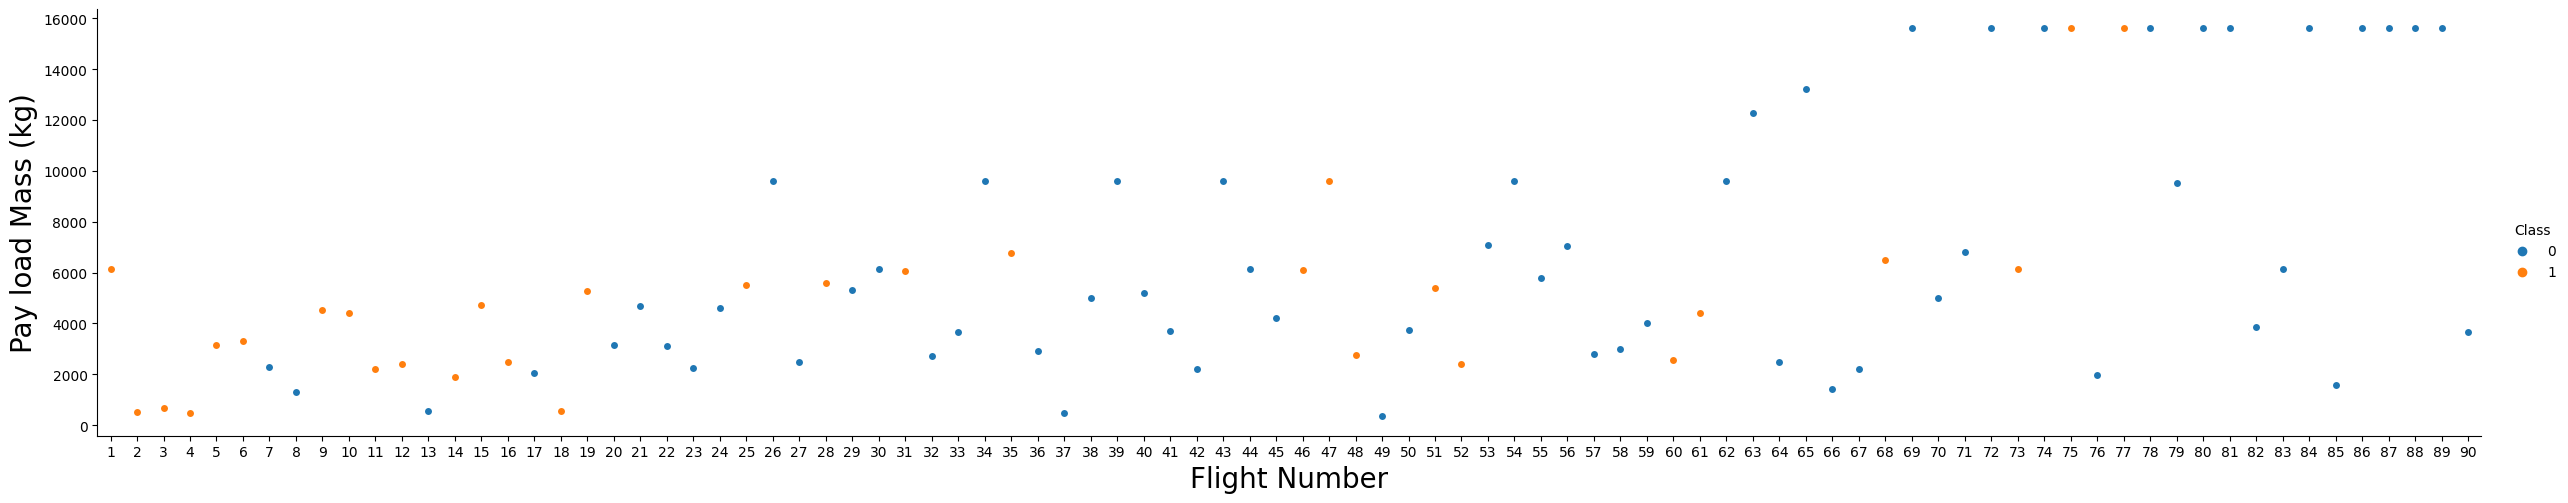

In [67]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

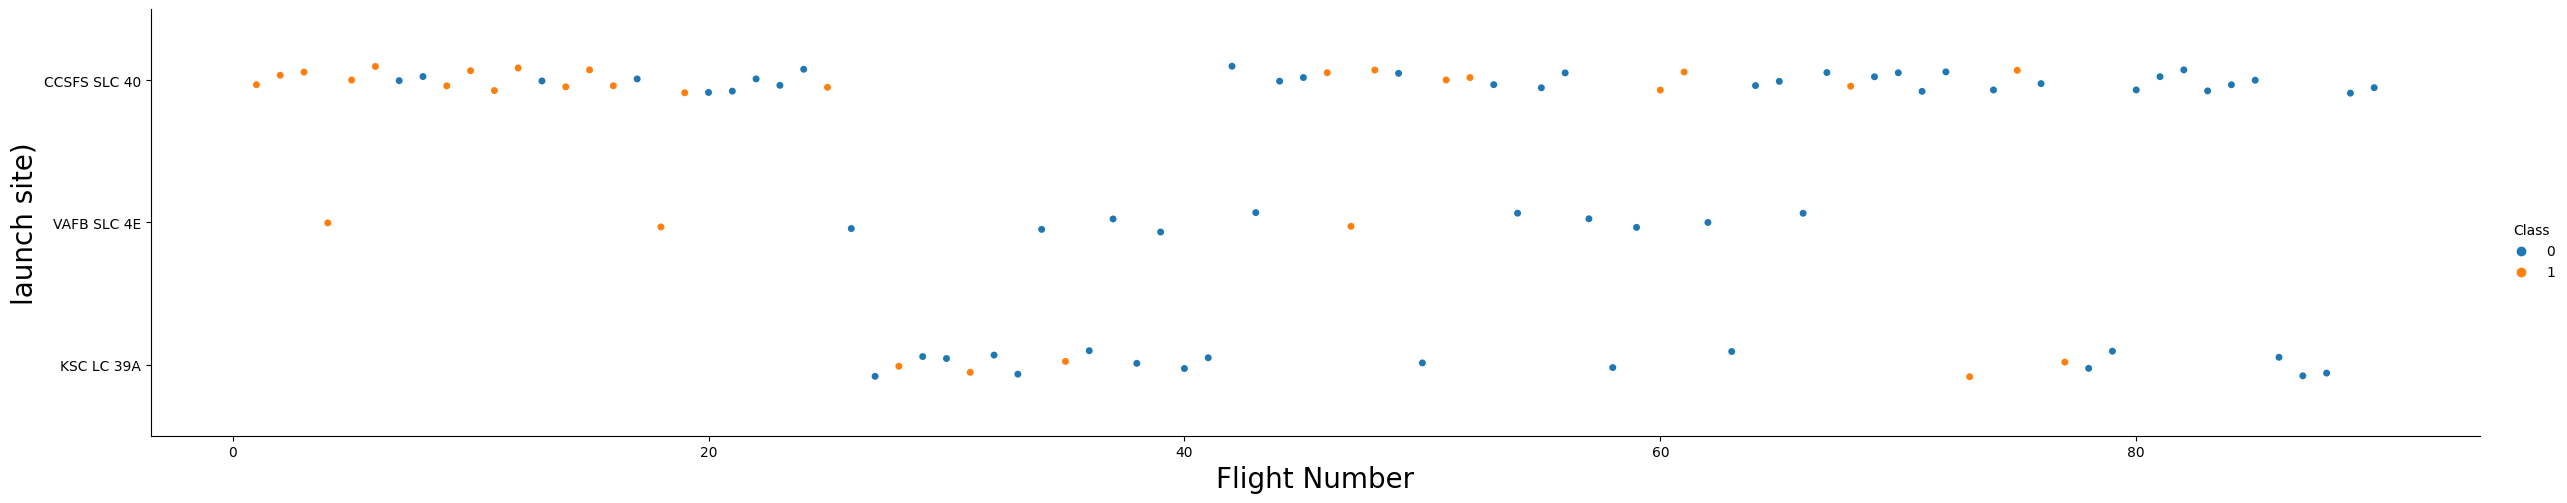

In [68]:

sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("launch site)",fontsize=20)
plt.show()

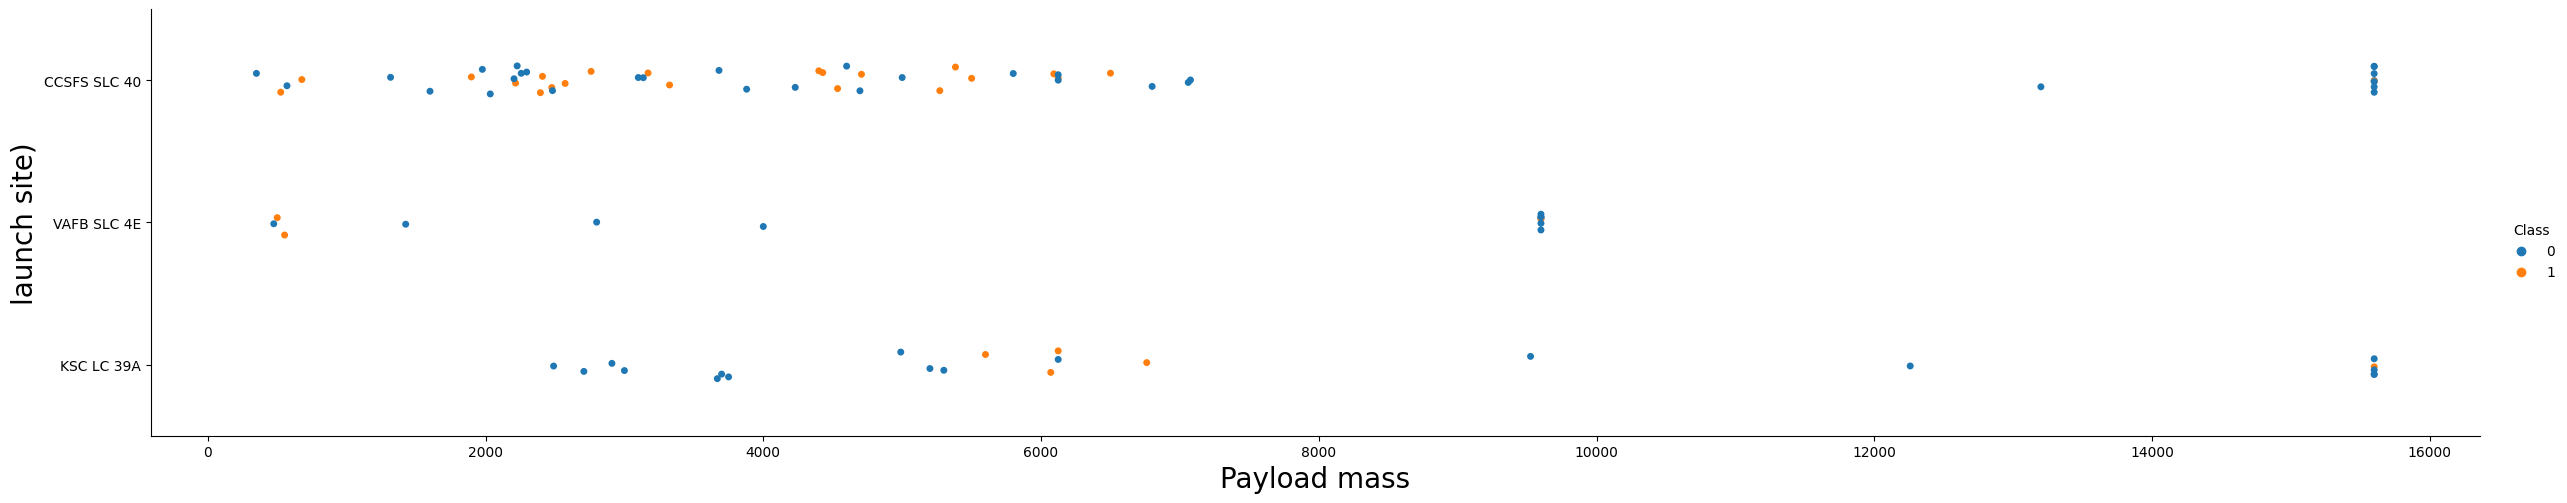

In [69]:
# Plot a scatter point chart with x axis to be Pay Load Mass (kg) and y axis to be the launch site, and hue to be the class value

sns.catplot(y="LaunchSite", x="PayloadMass", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Payload mass",fontsize=20)
plt.ylabel("launch site)",fontsize=20)
plt.show()

In [70]:
orbit_mean_class = data_falcon9.groupby('Orbit')['Class'].mean()
type(orbit_mean_class)

pandas.core.series.Series

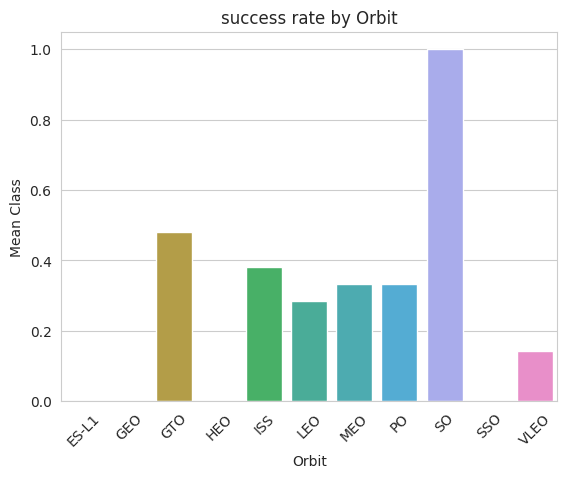

In [71]:
sns.set_style("whitegrid")

# Create the bar plot
sns.barplot(x=orbit_mean_class.index, y=orbit_mean_class.values)

# Set labels and title
plt.xlabel('Orbit')
plt.ylabel('Mean Class')
plt.title('success rate by Orbit')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

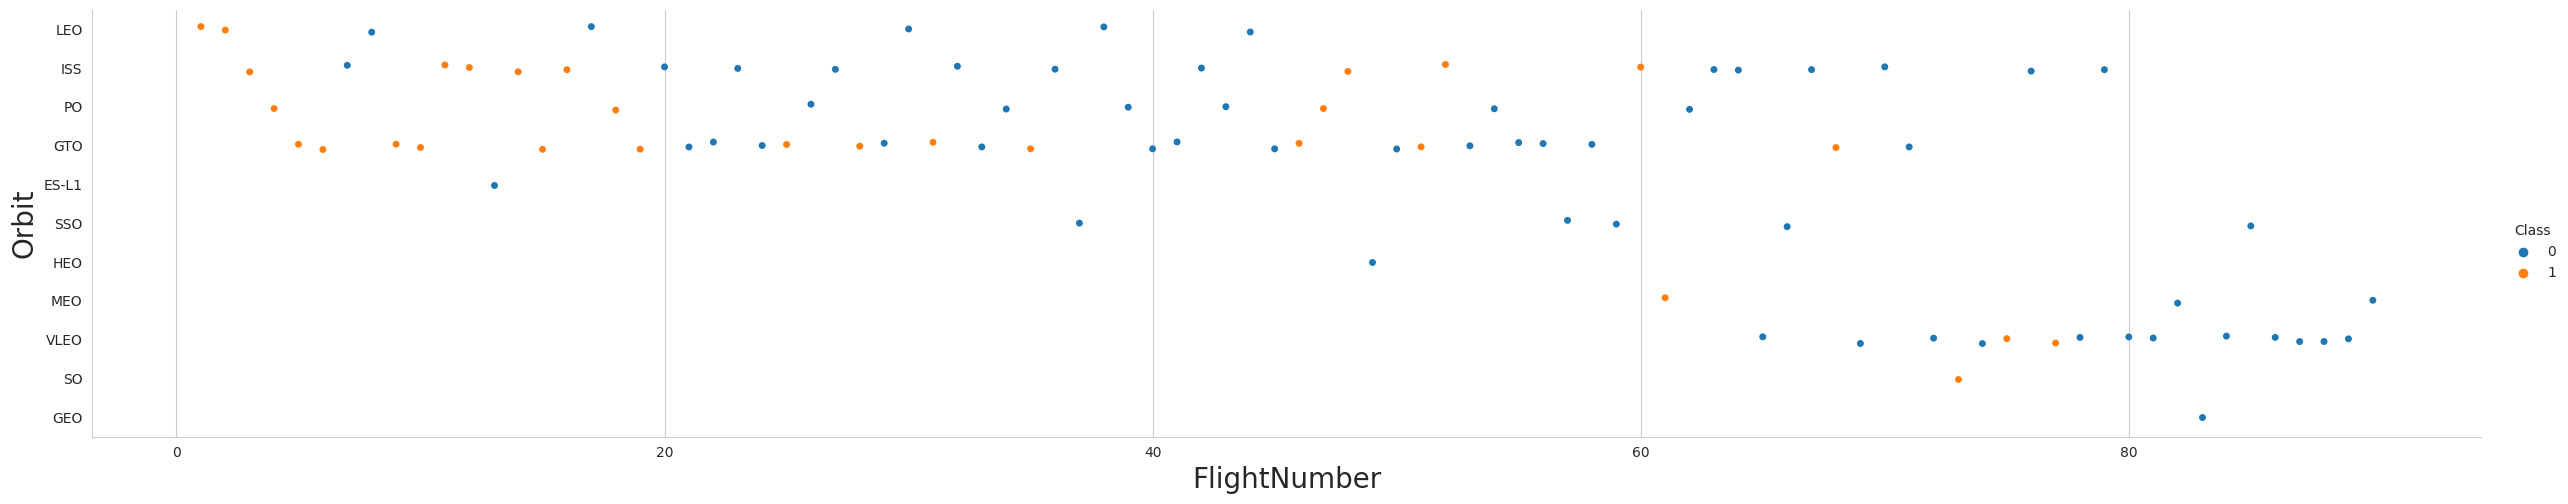

In [72]:
# Plot a scatter point chart with x axis to be FlightNumber and y axis to be the Orbit, and hue to be the class value
sns.catplot(y="Orbit", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("FlightNumber",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

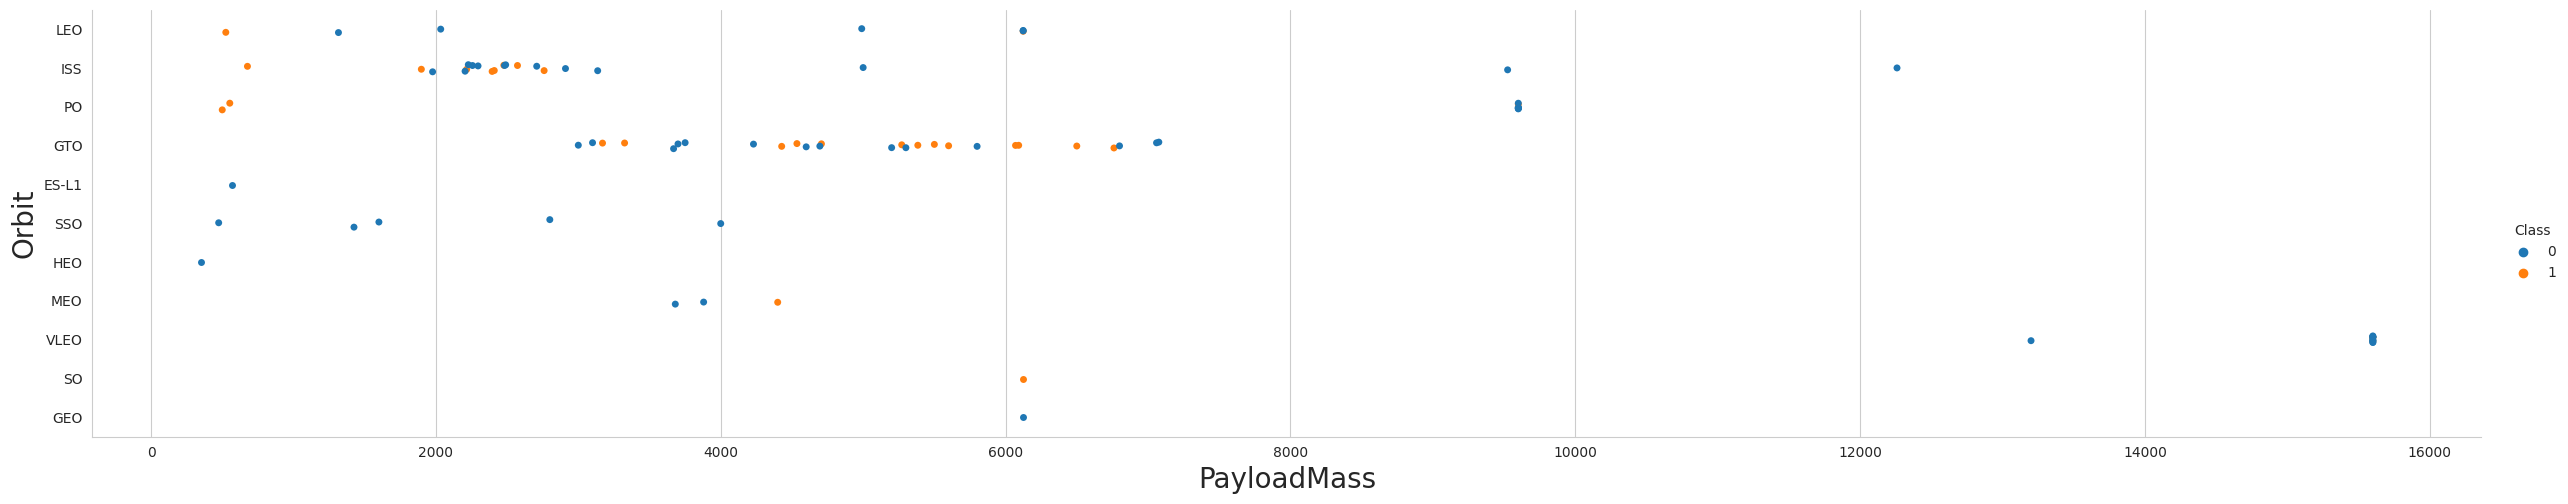

In [73]:
# Plot a scatter point chart with x axis to be Payload and y axis to be the Orbit, and hue to be the class value

sns.catplot(y="Orbit", x="PayloadMass", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("PayloadMass",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

 Visualize the launch success yearly trend

In [74]:
year_df = data_falcon9.copy()

In [75]:
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,1
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,1
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,1
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,1
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,1


In [76]:
year_df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,1
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,1
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,1
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,1
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,1


In [77]:
# A function to Extract years from the date
year=[]
def Extract_year(date):
    for i in data_falcon9["Date"]:
        year.append(i.split("-")[0])
    return year


In [86]:
# Convert the "Date" column to a string representing the year
data_falcon9["Year"] = data_falcon9["Date"].apply(lambda date: date.year)

# Now you can use the Extract_year function with the "Year" column
def Extract_year(year_column):
    year_list = []
    for i in year_column:
        year_list.append(str(i))
    return year_list



In [91]:
years = Extract_year(data_falcon9["Year"])

In [97]:
year_df['year'] = years

yearly_sucess = 1 -year_df.groupby('year')['Class'].mean()

Text(0.5, 1.0, 'Line Chart')

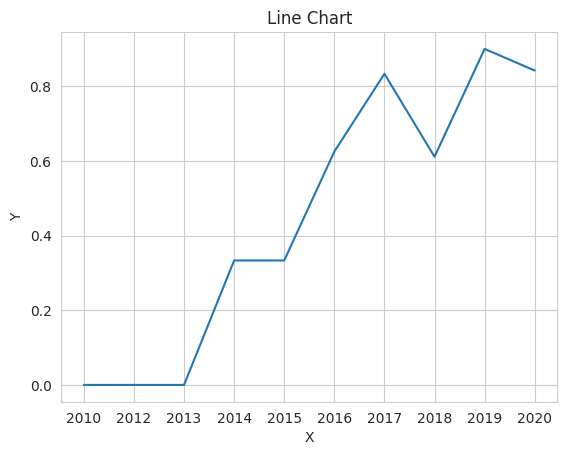

In [98]:
# Plot a line chart with x axis to be the extracted year and y axis to be the success rate
# Set the style of the plot
sns.set_style("whitegrid")

# Create the line plot
plt.plot(yearly_sucess.index, yearly_sucess.values)

# Set labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Line Chart')

In [99]:
yearly_sucess

year
2010    0.000000
2012    0.000000
2013    0.000000
2014    0.333333
2015    0.333333
2016    0.625000
2017    0.833333
2018    0.611111
2019    0.900000
2020    0.842105
Name: Class, dtype: float64

In [101]:
features = data_falcon9[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


In [102]:
features_one_hot = pd.get_dummies(features, columns=['Orbit', 'LaunchSite', 'LandingPad','Serial'])
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1,6123.547647,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,525.000000,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,3,677.000000,1,False,False,False,1.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4,500.000000,1,False,False,False,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,5,3170.000000,1,False,False,False,1.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [103]:
features_one_hot  = features_one_hot .astype('float64')


In [113]:
features_one_hot.head()


,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##Model Building


In [110]:
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

In [122]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['land', 'did not land']); ax.yaxis.set_ticklabels(['landed', ' did not land'])
    plt.show()

In [112]:
Y = data_falcon9['Class'].to_numpy()

Standardize the data in one_hot_features then reassign it to the variable X using the transform provided below.

In [114]:
transform = preprocessing.StandardScaler()
X = transform.fit(features_one_hot).transform(features_one_hot)

Use the function train_test_split to split the data X and Y into training and test data

In [115]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [116]:
Y_test.shape


(18,)

##Logistic Regression

In [117]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [118]:

lr=LogisticRegression()
logreg_cv = GridSearchCV(estimator=lr, cv=10, param_grid=parameters).fit(X_train, Y_train)

In [119]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8214285714285714


In [120]:
logreg_score = logreg_cv.score(X_test, Y_test)
print("score :", logreg_score)


score : 0.8333333333333334


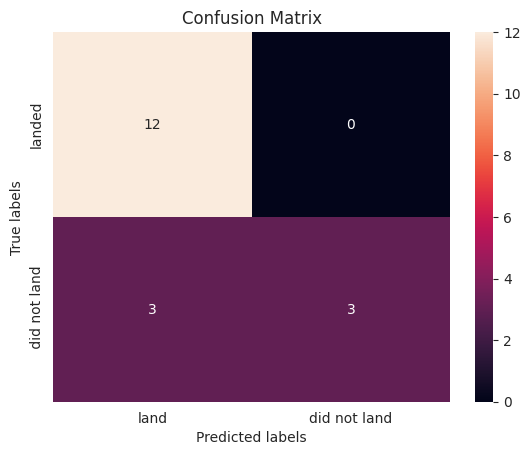

In [123]:
logreg_yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,logreg_yhat)

##support vector machine

In [124]:

parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv = GridSearchCV(estimator=svm, cv=10, param_grid=parameters).fit(X_train, Y_train)

In [125]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8357142857142857


In [126]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8357142857142857


In [127]:
svm_cv_score = svm_cv.score(X_test, Y_test)
print("score :",svm_cv_score)

score : 0.8333333333333334


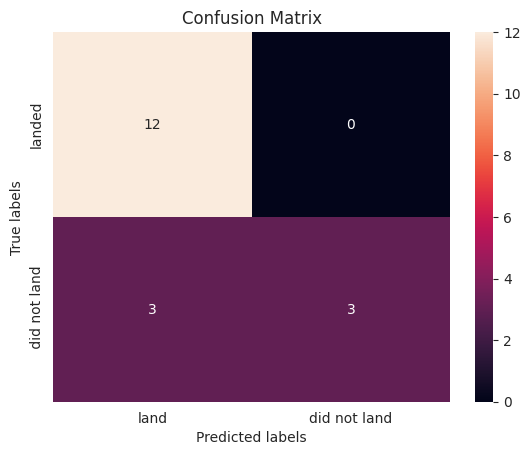

In [128]:
svm_yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,svm_yhat)

##Decision tree classifier


In [ ]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(estimator=tree, cv=10, param_grid=parameters).fit(X_train, Y_train)

In [130]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)


tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
accuracy : 0.8607142857142858


In [131]:
tree_cv_score = svm_cv.score(X_test, Y_test)
print("score :",tree_cv_score)

score : 0.8333333333333334


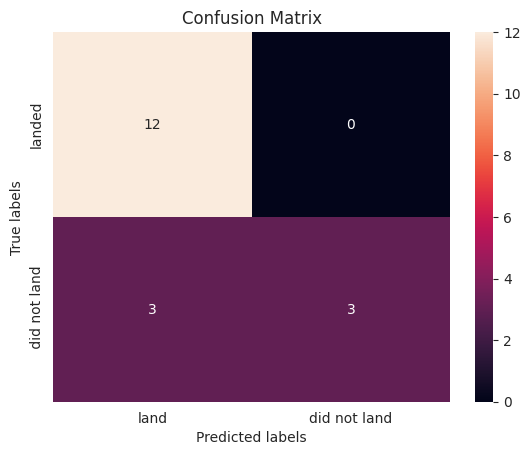

In [132]:
tree_yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,tree_yhat)

#KNN


In [133]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(estimator=KNN, cv=10, param_grid=parameters).fit(X_train, Y_train)

In [134]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
accuracy : 0.8339285714285714


In [135]:
knn_cv_score = knn_cv.score(X_test, Y_test)
print("score :",knn_cv_score)

score : 0.7777777777777778


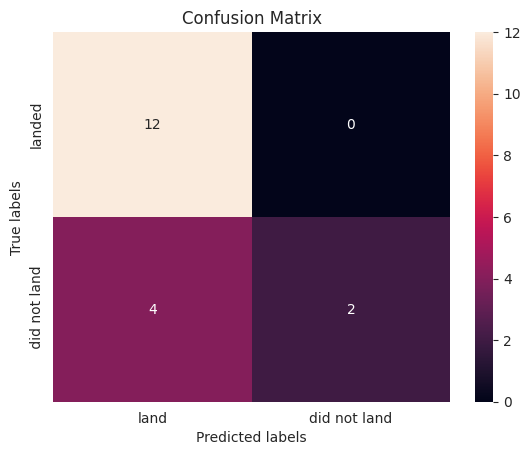

In [136]:
knn_yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,knn_yhat)

##compare models

In [137]:
accuracy = [svm_cv_score, logreg_score, knn_cv_score, tree_cv_score]
accuracy = [i * 100 for i in accuracy]

method = ['Support Vector Machine', 'Logistic Regression', 'K Nearest Neighbour', 'Decision Tree']
models = {'ML Method':method, 'Accuracy Score (%)':accuracy}

ML_df = pd.DataFrame(models)
ML_df

,ML Method,Accuracy Score (%)
0,Support Vector Machine,83.333333
1,Logistic Regression,83.333333
2,K Nearest Neighbour,77.777778
3,Decision Tree,83.333333


In [138]:
from sklearn.metrics import jaccard_score, f1_score

# Examining the scores from Test sets
jaccard_scores = [
                  jaccard_score(Y_test, logreg_yhat, average='binary'),
                  jaccard_score(Y_test, svm_yhat, average='binary'),
                  jaccard_score(Y_test, tree_yhat, average='binary'),
                  jaccard_score(Y_test, knn_yhat, average='binary'),
                 ]

f1_scores = [
             f1_score(Y_test, logreg_yhat, average='binary'),
             f1_score(Y_test, svm_yhat, average='binary'),
             f1_score(Y_test, tree_yhat, average='binary'),
             f1_score(Y_test, knn_yhat, average='binary'),
            ]

accuracy = [logreg_score, svm_cv_score, tree_cv_score, knn_cv_score]

scores_test = pd.DataFrame(np.array([jaccard_scores, f1_scores, accuracy]), index=['Jaccard_Score', 'F1_Score', 'Accuracy'] , columns=['LogReg', 'SVM', 'Tree', 'KNN'])
scores_test

,LogReg,SVM,Tree,KNN
Jaccard_Score,0.500000,0.500000,0.500000,0.333333
F1_Score,0.666667,0.666667,0.666667,0.500000
Accuracy,0.833333,0.833333,0.833333,0.777778


In [139]:
models = {'KNeighbors':knn_cv.best_score_,
              'DecisionTree':tree_cv.best_score_,
              'LogisticRegression':logreg_cv.best_score_,
              'SupportVector': svm_cv.best_score_}

bestalgorithm = max(models, key=models.get)
print('Best model is', bestalgorithm,'with a score of', models[bestalgorithm])
if bestalgorithm == 'DecisionTree':
    print('Best params is :', tree_cv.best_params_)
if bestalgorithm == 'KNeighbors':
    print('Best params is :', knn_cv.best_params_)
if bestalgorithm == 'LogisticRegression':
    print('Best params is :', logreg_cv.best_params_)
if bestalgorithm == 'SupportVector':
    print('Best params is :', svm_cv.best_params_)

Best model is DecisionTree with a score of 0.8607142857142858
Best params is : {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
